**Note** Final report  

- Giá lấy log scale -> phân phối gần chuẩn
- Used distance bị nhiễu -> không nhập (0), nhập sai (rất lớn)
- Brand và series có hiện tượng bị lệch (có brand - serie phổ biến, có cái lại rất ít)
- Các đời gần đây nhiều dần, những đời cũ ít dần. Giá xe tăng theo đời xe (càng gần càng đắt). Tuy vậy thì không chắc số km đã đi có xu hướng như vậy
- Serie có quan hệ 1-1 với số cửa và số ghế  -> có thể bỏ được thông tin này
- Loại hộp số - loại dẫn động: không chắc chắn. có thể cùng serie nhưng khác đời -> khác thông tin. Cần có kinh nghiệm để biết trường này có quan hệ 1-1 với (serie) hoặc (serie + model_year) không
- Dung tích xy lanh: tương tự loại hộp số, dẫn động

Final: có thể bỏ được (loại hộp số, dẫn động, dung tích xy lanh). Có thể tạo thêm 1 số trường mới như:  
- Số km đi trung bình theo năm
- log của số km đã đi
- log của giá (có thể sẽ predict trên log của giá)

# Phân tích ban đầu

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('./preprocessed_data.csv')

In [3]:
df = df.astype({
    'model_year': 'Int64'
})

df['log_price_vnd'] = np.log(df['price_vnd'] + 1)
df['log_used_distance'] = np.log(df['used_distance'] + 1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41613 entries, 0 to 41612
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   url                41613 non-null  object 
 1   brand              41613 non-null  object 
 2   serie              41137 non-null  object 
 3   model_year         41037 non-null  Int64  
 4   price_vnd          41613 non-null  int64  
 5   date               41613 non-null  object 
 6   origin             41613 non-null  object 
 7   status             41613 non-null  object 
 8   category           41613 non-null  object 
 9   used_distance      41613 non-null  int64  
 10  out_color          41613 non-null  object 
 11  in_color           41613 non-null  object 
 12  num_door           41613 non-null  int64  
 13  num_seat           41613 non-null  int64  
 14  gear_type          41613 non-null  object 
 15  drive_type         41613 non-null  object 
 16  cylinder_capacity  394

In [6]:
df['category'].value_counts()

Sedan                    14611
SUV                      11573
Hatchback                 5293
Crossover                 3797
Bán tải / Pickup        2307
Van/Minivan               2142
Truck                     1631
Coupe                      149
Convertible/Cabriolet       98
Wagon                       12
Name: category, dtype: int64

In [4]:
df.describe()

,model_year,price_vnd,used_distance,num_door,num_seat,cylinder_capacity,log_price_vnd,log_used_distance
count,41037.000000,41613.000000,4.161300e+04,41613.000000,41613.000000,39465.000000,41613.000000,41613.000000
mean,2015.695592,997.655180,1.973842e+05,4.421503,5.700190,1.981114,6.292268,4.749095
std,5.630388,1895.902402,2.124916e+07,0.995241,2.524158,0.780145,1.022011,5.349119
min,1990.000000,1.000000,0.000000e+00,0.000000,0.000000,0.100000,0.693147,0.000000
25%,2012.000000,305.000000,0.000000e+00,4.000000,5.000000,1.500000,5.723585,0.000000
50%,2017.000000,528.000000,0.000000e+00,5.000000,5.000000,2.000000,6.270988,0.000000
75%,2021.000000,900.000000,4.500000e+04,5.000000,7.000000,2.200000,6.803505,10.714440
max,2022.000000,42500.000000,4.294967e+09,56.000000,47.000000,12.900000,10.657283,22.180710


## Một số câu hỏi

- Có phải tất cả các xe Mazda CX5 đều có 4 cửa, 5 chỗ. Nghĩa là nếu thông tin map 1-1 thì có thể bỏ thông tin số cửa, số chỗ
- Có phải cùng dòng xe đều có chung dung tích xi lanh (cylinder_capacity). Nếu đúng, có thể bỏ không? (dung tích xi lanh có ảnh hưởng gì đến giá không)
- used_distance có std lớn gấp 100 lần mean -> dữ liệu nhập sai, phải clean
- Kiểm tra dữ liệu về giá

## Phân tích các trường đơn lẻ
### Các trường numeric

#### Giá
Nhận thấy có rất nhiều dữ liệu không nhập số km đã đi(quá 1 nửa đều là 0). Và số km đã đi cũng bị nhập sai, có những điểm số km đã đi rất lớn (e mũ 22)

<AxesSubplot:xlabel='log_price_vnd', ylabel='Count'>

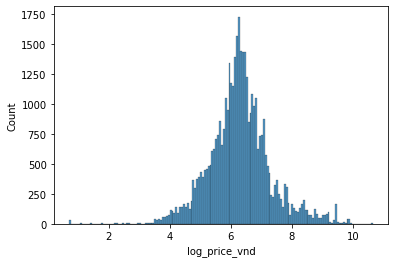

In [5]:
sns.histplot(df['log_price_vnd'])

<AxesSubplot:xlabel='price_vnd', ylabel='Count'>

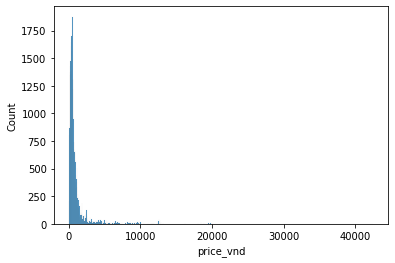

In [6]:
sns.histplot(df['price_vnd'])

In [7]:
df['log_price_vnd'].describe()

count    41613.000000
mean         6.292268
std          1.022011
min          0.693147
25%          5.723585
50%          6.270988
75%          6.803505
max         10.657283
Name: log_price_vnd, dtype: float64

In [8]:
df['price_vnd'].describe()

count    41613.000000
mean       997.655180
std       1895.902402
min          1.000000
25%        305.000000
50%        528.000000
75%        900.000000
max      42500.000000
Name: price_vnd, dtype: float64

#### Số km đã đi

<AxesSubplot:xlabel='log_used_distance', ylabel='Count'>

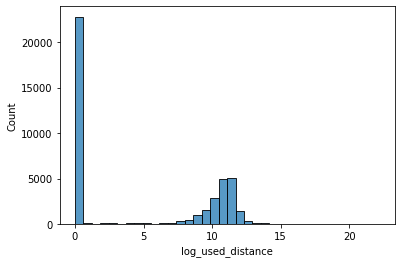

In [9]:
sns.histplot(df['log_used_distance'])

In [10]:
df['log_used_distance'].describe()

count    41613.000000
mean         4.749095
std          5.349119
min          0.000000
25%          0.000000
50%          0.000000
75%         10.714440
max         22.180710
Name: log_used_distance, dtype: float64

In [11]:
df['used_distance'].describe()

count    4.161300e+04
mean     1.973842e+05
std      2.124916e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      4.500000e+04
max      4.294967e+09
Name: used_distance, dtype: float64

#### Dung tích xi lanh (cylinder_capacity)

/home/huytung/.pyenv/versions/3.8.12/envs/ai/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='cylinder_capacity', ylabel='Density'>

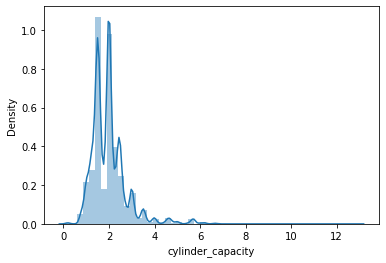

In [12]:
sns.distplot(df['cylinder_capacity'])

In [13]:
df['cylinder_capacity'].describe()

count    39465.000000
mean         1.981114
std          0.780145
min          0.100000
25%          1.500000
50%          2.000000
75%          2.200000
max         12.900000
Name: cylinder_capacity, dtype: float64

### Các trường category

#### Brand

In [14]:
df['brand'].nunique()

77

In [15]:
popular_brands = df['brand'].value_counts()[(df['brand'].value_counts() > 1000)]
popular_brands

Toyota           8682
Hyundai          4892
Kia              4526
Ford             3750
Mercedes Benz    3491
Mazda            2431
Mitsubishi       1671
Honda            1624
VinFast          1308
Chevrolet        1169
Name: brand, dtype: int64

Tổng số xe thuộc các hãng phổ biến và phần trăm của nó

In [16]:
number_of_car_in_popular_brands = popular_brands.sum()

In [17]:
popular_brands_percentage = {}

for brand, num_car in popular_brands.items():
    popular_brands_percentage[brand] = round(num_car/df.shape[0], 2)
    
popular_brands_percentage

{'Toyota': 0.21,
 'Hyundai': 0.12,
 'Kia': 0.11,
 'Ford': 0.09,
 'Mercedes Benz': 0.08,
 'Mazda': 0.06,
 'Mitsubishi': 0.04,
 'Honda': 0.04,
 'VinFast': 0.03,
 'Chevrolet': 0.03}

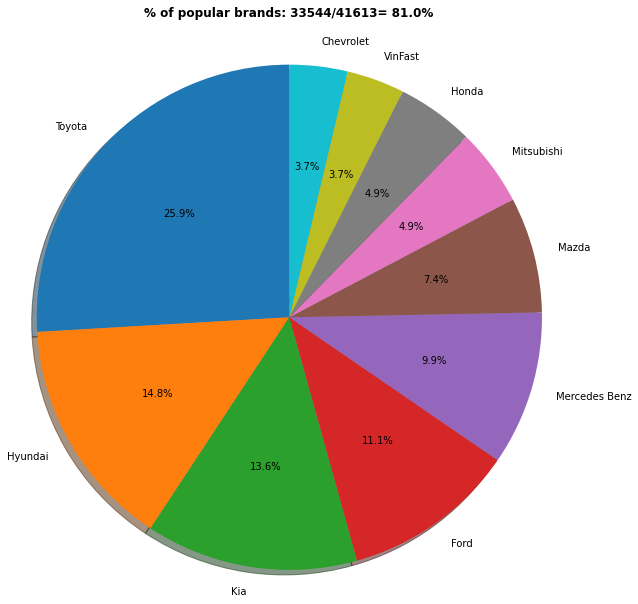

In [18]:
fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(popular_brands_percentage.values(), labels=popular_brands_percentage.keys(), \
        autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')
ax1.set_title(f'% of popular brands: {number_of_car_in_popular_brands}/{df.shape[0]}' + \
              f'= {round(number_of_car_in_popular_brands/df.shape[0],2)*100}%', pad=30, fontweight='bold')
plt.show()

In [19]:
medium_brands = df['brand'].value_counts()[
    (df['brand'].value_counts() <= 1000) & 
    (df['brand'].value_counts() > 50)
]
medium_brands

Daewoo        996
Lexus         985
Suzuki        743
BMW           737
Nissan        601
LandRover     554
Hãng khác     476
MG            320
Porsche       304
Thaco         295
Isuzu         291
Audi          287
Peugeot       249
Volkswagen    163
Volvo         122
Bentley       116
Subaru        113
Mini           94
Cadillac       58
Fiat           52
Name: brand, dtype: int64

Số phần trăm xe thuộc các hãng trung bình rất thấp (nhỏ nhất 0.1%)

Số xe thuộc phân khúc dưới 50 xe được quan sát gần như không đáng kể, có thể sẽ phải bỏ qua

In [20]:
number_of_car_in_medium_brands = medium_brands.sum()

medium_brands_percentage = {}

for brand, num_car in medium_brands.items():
    medium_brands_percentage[brand] = round(num_car/df.shape[0], 4) * 100
    
medium_brands_percentage

{'Daewoo': 2.39,
 'Lexus': 2.37,
 'Suzuki': 1.79,
 'BMW': 1.77,
 'Nissan': 1.44,
 'LandRover': 1.3299999999999998,
 'Hãng khác': 1.1400000000000001,
 'MG': 0.77,
 'Porsche': 0.73,
 'Thaco': 0.7100000000000001,
 'Isuzu': 0.7000000000000001,
 'Audi': 0.69,
 'Peugeot': 0.6,
 'Volkswagen': 0.38999999999999996,
 'Volvo': 0.29,
 'Bentley': 0.27999999999999997,
 'Subaru': 0.27,
 'Mini': 0.22999999999999998,
 'Cadillac': 0.13999999999999999,
 'Fiat': 0.12}

#### Năm sản xuất

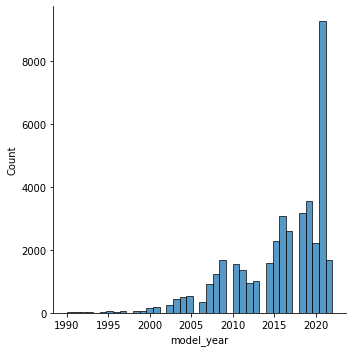

In [21]:
sns.displot(data=df, x='model_year', bins=40)

Số xe hiện rao bán các năm càng lâu càng ít dần, giá những năm gần đây cao

Tuy vậy thì không chắc các điểm này là outliner - nhập sai. Có thể do brand-series. Cần phân tích thêm và lọc

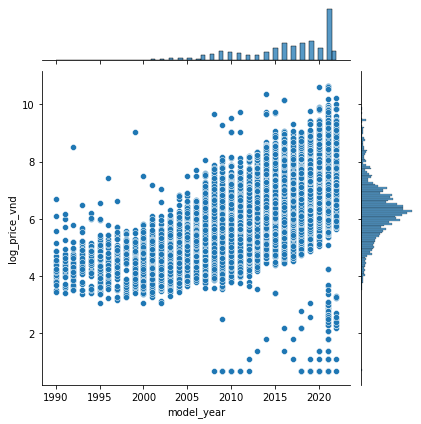

In [22]:
sns.jointplot(data=df, x='model_year', y='log_price_vnd', kind="scatter")

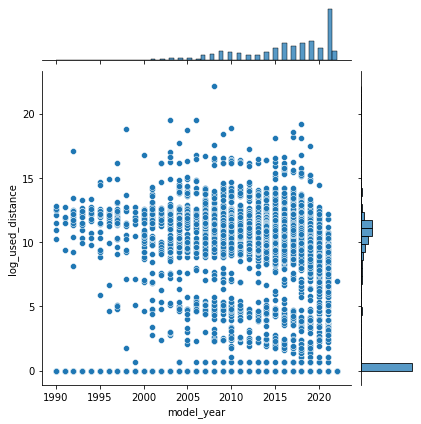

In [23]:
sns.jointplot(data=df, x='model_year', y='log_used_distance', kind="scatter")

#### Xuất xứ + Trạng thái

<AxesSubplot:xlabel='origin', ylabel='count'>

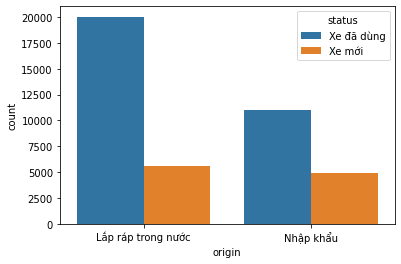

In [24]:
sns.countplot(data=df, x='origin', hue='status')

<AxesSubplot:xlabel='origin', ylabel='log_used_distance'>

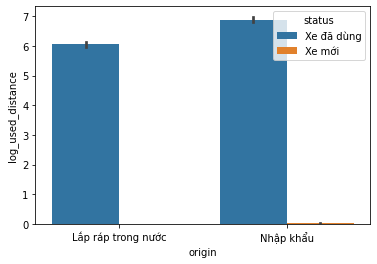

In [25]:
sns.barplot(data=df, x='origin', y='log_used_distance', hue='status')

<AxesSubplot:xlabel='origin', ylabel='log_price_vnd'>

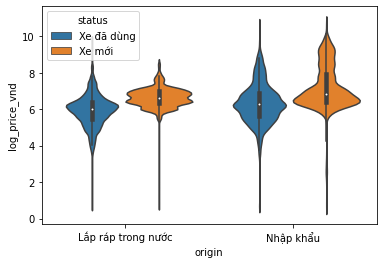

In [26]:
sns.violinplot(data=df, x='origin', y='log_price_vnd', hue='status')

#### Màu sắc

<AxesSubplot:xlabel='in_color', ylabel='out_color'>

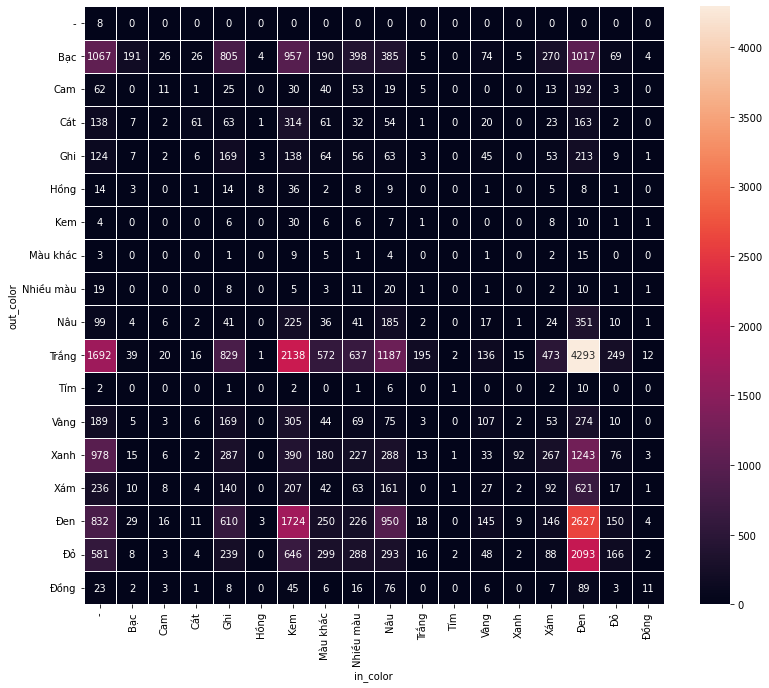

In [27]:
correlation_by_in_out_col = df.groupby(['in_color', 'out_color']).count()['url']

correlation_matrix = correlation_by_in_out_col.unstack('in_color').fillna(0).astype(int)

f, ax = plt.subplots(figsize=(13, 11))
sns.heatmap(correlation_matrix, annot=True, fmt="d", linewidths=.5, ax=ax)

#### Số cửa

Có thể khá chắc chắn thông tin về số cửa quan hệ 1-1 với serie xe. Sai có thể do người dùng nhầm (xe 4, 5 cửa) khá giống nhau

Tương tự với num_seat

##### Phân tích về số cửa

In [28]:
correlation_by_in_out_col = df.groupby(['serie', 'num_door']).count()['url']

correlation_matrix = correlation_by_in_out_col.unstack('num_door').fillna(0).astype(int)

not_1_1_relationship_idx = []

for index, row in correlation_matrix.iterrows():
    if len(row[row > 0]) > 1:
        not_1_1_relationship_idx.append(index)

In [29]:
correlation_matrix[correlation_matrix.index.isin(not_1_1_relationship_idx)][0:20]

num_door,0,1,2,3,4,5,6,7,8,40,45,50,54,55,56
serie,,,,,,,,,,,,,,,
2,0,0,0,0,154,72,0,0,0,0,0,0,0,0,0
2008,0,0,0,0,3,49,0,0,0,0,0,0,0,0,0
208,0,0,0,0,1,8,0,0,0,0,0,0,0,0,0
3,0,0,0,0,732,176,0,0,0,0,0,0,0,0,0
3 Series,0,0,9,0,229,2,0,0,0,0,0,0,0,0,0
3008,0,0,0,0,1,95,0,0,0,0,0,0,0,0,0
323,0,0,0,0,58,1,0,0,0,0,0,0,0,0,0
4 Series,0,0,10,0,13,0,0,0,0,0,0,0,0,0,0
405,0,0,0,0,3,1,0,0,0,0,0,0,0,0,0


##### Phân tích num_seat

In [30]:
correlation_by_in_out_col = df.groupby(['serie', 'num_seat']).count()['url']

correlation_matrix = correlation_by_in_out_col.unstack('num_seat').fillna(0).astype(int)

not_1_1_relationship_idx = []

for index, row in correlation_matrix.iterrows():
    if len(row[row > 0]) > 1:
        not_1_1_relationship_idx.append(index)

correlation_matrix[correlation_matrix.index.isin(not_1_1_relationship_idx)][0:20]

num_seat,0,1,2,3,4,5,6,7,8,9,...,34,35,38,39,40,41,44,45,46,47
serie,,,,,,,,,,,,,,,,,,,,,
1200B,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1240T,0,0,2,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2 Series,0,0,0,0,0,3,0,3,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,1,906,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3 Series,0,0,0,0,8,232,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3008,0,0,0,0,1,95,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4 Series,0,0,0,0,11,12,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
405,0,0,0,0,1,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6 Series,0,0,0,0,1,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


##### Phân tích về loại hộp số

Loại hộp số có thể không chỉ phụ thuộc vào dòng xe, mà còn phụ thuộc vào dòng + đời xe -> không bỏ được trường này

In [31]:
correlation_by_in_out_col = df.groupby(['serie', 'gear_type']).count()['url']

correlation_matrix = correlation_by_in_out_col.unstack('gear_type').fillna(0).astype(int)

not_1_1_relationship_idx = []

for index, row in correlation_matrix.iterrows():
    if len(row[row > 0]) > 1:
        not_1_1_relationship_idx.append(index)

correlation_matrix[correlation_matrix.index.isin(not_1_1_relationship_idx)][0:20]

gear_type,-,Số tay,Số tự động
serie,,,
2,0,1,225
3,0,4,904
3 Series,0,3,237
4 Runner,0,1,3
5 Series,0,4,170
6,0,21,251
APV,0,9,2
Accent,0,235,483
Accord,0,44,53


##### Phân tích về loại dẫn động

Thông tin này không quá chắc chắn -> hỏi thêm người hiểu rõ về xe

In [33]:
correlation_by_in_out_col = df.groupby(['serie', 'drive_type']).count()['url']

correlation_matrix = correlation_by_in_out_col.unstack('drive_type').fillna(0).astype(int)

not_1_1_relationship_idx = []

for index, row in correlation_matrix.iterrows():
    if len(row[row > 0]) > 1:
        not_1_1_relationship_idx.append(index)

correlation_matrix[correlation_matrix.index.isin(not_1_1_relationship_idx)][0:20]

drive_type,-,4WD - Dẫn động 4 bánh,4WD hoặc AWD,AWD - 4 bánh toàn thời gian,FWD - Dẫn động cầu trước,RFD - Dẫn động cầu sau
serie,,,,,,
3,1,0,0,0,907,0
3 Series,0,0,0,3,1,236
4 Runner,0,2,0,2,0,0
6,2,1,0,0,269,0
A class,0,0,0,10,14,0
A2,0,4,0,0,1,3
A4,1,0,0,5,29,0
A5,0,0,0,11,1,0
A6,0,0,0,2,37,0


##### Phân tích về dung tích xi lanh


Có vẻ như sẽ có thể bỏ được trường này

In [38]:
featured_series = df['serie'].value_counts()[:5].index
featured_series

Index(['Vios', 'Innova', 'Morning', 'Ranger', 'Fortuner'], dtype='object')

In [39]:
cyline_analysis_df = df[df['serie'].isin(featured_series)]

<AxesSubplot:xlabel='serie', ylabel='cylinder_capacity'>

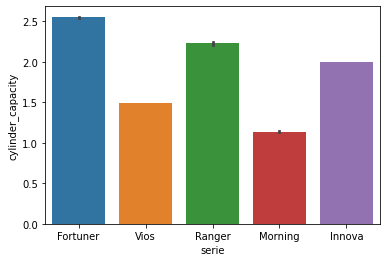

In [41]:
sns.barplot(data=cyline_analysis_df, x='serie', y='cylinder_capacity')

In [47]:
cyline_analysis_df.groupby('serie').mean()['cylinder_capacity']

serie
Fortuner    2.549586
Innova      2.000000
Morning     1.135401
Ranger      2.230385
Vios        1.495357
Name: cylinder_capacity, dtype: float64

In [48]:
cyline_analysis_df.groupby('serie').std()['cylinder_capacity']

serie
Fortuner    0.138640
Innova      0.000000
Morning     0.111825
Ranger      0.337897
Vios        0.030127
Name: cylinder_capacity, dtype: float64